<b> import statements

In [1]:
import sys

import numpy as np
import pandas as pd
import datetime
import time


import requests
import re
from bs4 import BeautifulSoup
from time import sleep
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid", {'axes.grid' : False})

In [2]:
from sklearn import cross_validation, datasets, linear_model, grid_search, metrics, ensemble, tree
from sklearn import pipeline, manifold, preprocessing, feature_selection, decomposition
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import cross_val_score

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

/Users/Cyril/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Cyril/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/Cyril/anaconda/lib/python3.6/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  

In [3]:
from pandas import Series, DataFrame, Panel
import scipy; 
import scipy.stats as stats; 
from scipy.stats import ttest_ind, ttest_ind_from_stats; from scipy.special import stdtr; 

<b> defining lobster

In [4]:
from pandas import DataFrame, read_csv, concat
from os import path
import numpy as np
from datetime import timedelta
from enum import Enum

class OrderEvent(Enum):
    SUBMISSION = 1
    CANCELLATION = 2
    DELETION = 3
    EXECUTION = 4
    HIDDEN_EXECUTION =5
    CROSS_TRADE = 6
    TRADING_HALT  = 7
    OTHER = 8

__EventMap = {}

for e in OrderEvent:
    __EventMap[e.value] = e

def get_orderEvent(eventid):
    return __EventMap[eventid]


class LobsterData:
    def __init__(self):
        self.order_books = None
        self.messages = DataFrame()
        self.level = 0

    def read_single_day_data(self, order_book_file, message_file, append=True, convert_time=False):
        file_name = path.basename(order_book_file)
        file_base = path.splitext(file_name)[0]
        mydate = np.datetime64('{0}T00:00-0000'.format(file_base.split('_')[1]))

        myorderbooks = read_csv(order_book_file, header=None)
        mymessages = read_csv(message_file, header=None)
        columns = []
        for iCol in range(int(len(myorderbooks.columns) / 4 + 0.5)):
            columns.append('Ask_Price_{0}'.format(iCol + 1))
            columns.append('Ask_Size_{0}'.format(iCol + 1))
            columns.append('Bid_Price_{0}'.format(iCol + 1))
            columns.append('Bid_Size_{0}'.format(iCol + 1))
        myorderbooks.columns = columns
        mymessages.columns = ['Time', 'Event', 'Order_ID', 'Size', 'Price', 'Direction']
        mymessages.Event = mymessages['Event'].map(get_orderEvent)
        mymessages['Date'] = mydate
        if convert_time:
            mymessages.Time = mymessages.Time.apply(lambda x: mydate + np.timedelta64(int(x * 1e9), 'ns'))

        mymessages.set_index(['Date', 'Time'], inplace=True)
        myorderbooks.index = mymessages.index

        if append:
            self.order_books = concat([self.order_books, myorderbooks], axis=0)
            self.messages = concat([self.messages, mymessages], axis=0)
        else:
            self.order_books = myorderbooks
            self.messages = mymessages
        self.level = int(self.order_books.shape[1] / 4 + 0.5)

    def read_period_data(self, ticker, level, start_date, end_date, data_path='./', **kwargs):
        my_date = start_date
        while my_date <= end_date:
            print('read {0}'.format(my_date.strftime('%Y-%m-%d')))
            order_book_file = "{0}/{1}_{2}_34200000_57600000_orderbook_{3}.csv".format(data_path, ticker,
                                                                                       my_date.strftime('%Y-%m-%d'),
                                                                                       level)

            message_file = "{0}/{1}_{2}_34200000_57600000_message_{3}.csv".format(data_path, ticker,
                                                                                       my_date.strftime('%Y-%m-%d'),
                                                                                       level)
            self.read_single_day_data(order_book_file, message_file, **kwargs)
            my_date += timedelta(1)

    def get_number_of_record(self):
        return self.order_books.shape[0]

    def get_number_of_level(self):
        return self.level

    def get_trades(self, combined=True, combination_interval=100):
        pass
    
    def exclude_trade_halt_data(self):
        halt_indicators = where(self.message.event == 7)
        
    def plot_orderbook(self):
        pass


Output Structure:
---------------

LOBSTER generates a 'message' and an 'orderbook' file for each active 
trading day of a selected ticker. The 'orderbook' file contains the 
evolution of the limit order book up to the requested number of levels. 
The 'message' file contains indicators for the type of event causing 
an update of the limit order book in the requested price range. All 
events are timestamped to seconds after midnight, with decimal 
precision of at least milliseconds and up to nanoseconds depending 
on the requested period. 


	Message File:		(Matrix of size: (Nx6))
	-------------	
			
	Name: 	TICKER_Year-Month-Day_StartTime_EndTime_message_LEVEL.csv 	
		
		StartTime and EndTime give the theoretical beginning 
		and end time of the output file in milliseconds after 		
		mid night. LEVEL refers to the number of levels of the 
		requested limit order book.


	Columns:
	
	    1.) Time: 		
				Seconds after midnight with decimal 
				precision of at least milliseconds 
				and up to nanoseconds depending on 
				the requested period
	    2.) Type:
				1: Submission of a new limit order
				2: Cancellation (Partial deletion 
				   of a limit order)
				3: Deletion (Total deletion of a limit order)
				4: Execution of a visible limit order			   	 
				5: Execution of a hidden limit order
				7: Trading halt indicator 				   
				   (Detailed information below)
	    3.) Order ID: 	
				Unique order reference number 
				(Assigned in order flow)
	    4.) Size: 		
				Number of shares
	    5.) Price: 		
				Dollar price times 10000 
				(i.e., A stock price of $91.14 is given 
				by 911400)
	    6.) Direction:
				-1: Sell limit order
				1: Buy limit order
				
				Note: 
				Execution of a sell (buy) limit
				order corresponds to a buyer (seller) 
				initiated trade, i.e. Buy (Sell) trade.
										
						
	Orderbook File:		(Matrix of size: (Nx(4xNumberOfLevels)))
	---------------
	
	Name: 	TICKER_Year-Month-Day_StartTime_EndTime_orderbook_LEVEL.csv
	
	Columns:
	
 	    1.) Ask Price 1: 	Level 1 Ask Price 	(Best Ask)
	    2.) Ask Size 1: 	Level 1 Ask Volume 	(Best Ask Volume)
	    3.) Bid Price 1: 	Level 1 Bid Price 	(Best Bid)
	    4.) Bid Size 1: 	Level 1 Bid Volume 	(Best Bid Volume)
	    5.) Ask Price 2: 	Level 2 Ask Price 	(2nd Best Ask)
	    ...
	
	Notes: 	 
	------
	
		- Levels:
		
		The term level refers to occupied price levels. This implies 
		that the difference between two levels in the LOBSTER output 
		is not necessarily the minimum ticks size.

		- Unoccupied Price Levels:
	
		When the selected number of levels exceeds the number of levels 
		available the empty order book positions are filled with dummy 
		information to guarantee a symmetric output. The extra bid 
		and/or ask prices are set to -9999999999 and 9999999999, 
		respectively. The Corresponding volumes are set to 0. 
		
		- Trading Halts:
		
		When trading halts, a message of type '7' is written into the 
		'message' file. The corresponding price and trade direction 
		are set to '-1' and all other properties are set to '0'. 
		Should the resume of quoting be indicated by an additional 
		message in NASDAQ's Historical TotalView-ITCH files, another 
		message of type '7' with price '0' is added to the 'message' 
		file. Again, the trade direction is set to '-1' and all other 
		fields are set to '0'. 
		When trading resumes a message of type '7' and 
		price '1' (Trade direction '-1' and all other 
		entries '0') is written to the 'message' file. For messages 
		of type '7', the corresponding order book rows contain a 
		duplication of the preceding order book state. The reason 
		for the trading halt is not included in the output.
						
			Example: Stylized trading halt messages in 'message' file.				
		
			Halt: 				36023	| 7 | 0 | 0 | -1 | -1
											...
			Quoting: 			36323 	| 7 | 0 | 0 | 0  | -1
											...
			Resume Trading:		36723   | 7 | 0 | 0 | 1  | -1
											...

			The vertical bars indicate the different columns in the  
			message file.

=========================================================================


In [5]:
d = LobsterData()

In [6]:
d.read_single_day_data('AMZN_2012-06-21_34200000_57600000_orderbook_5.csv', 'AMZN_2012-06-21_34200000_57600000_message_5.csv', append=True, convert_time=False)

/Users/Cyril/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


In [7]:
print(d.get_number_of_record())

155935


In [8]:
print(d.get_number_of_level())

5


In [9]:
ob = read_csv('AMZN_2012-06-21_34200000_57600000_orderbook_5.csv', header=None)
mb = read_csv('AMZN_2012-06-21_34200000_57600000_message_5.csv', header=None)

<b> PART 0 - GET THE RELEVANT STRUCTURES <br/>
1- the 5-level limit order book --> used to get the S's <br/>
2- the buy/sell limit orders placed --> used to get the L's <br/>
3- the buy/sell market orders executed --> used to get the M's <br/>
4- the buy/sell cancelled orders --> used to get the C's

In [10]:
# 1- the 5-level limit order book
lob = d.order_books
Time = []
Date = []
for idx,row in lob.iterrows():
    Time.append(idx[1])
lob['Time'] = Time
lob.tail()

Ask_Price_1  Ask_Size_1  Bid_Price_1  Bid_Size_1  \
Date       Time                                                             
2012-06-21 57599.545828      2206200         100      2205100         249   
           57599.903989      2206400         100      2205100         249   
           57599.955242      2206400         100      2205100         249   
           57599.958245      2206300         100      2205100         249   
           57599.959360      2206400         100      2205100         249   

                         Ask_Price_2  Ask_Size_2  Bid_Price_2  Bid_Size_2  \
Date       Time                                                             
2012-06-21 57599.545828      2206400         100      2205000          71   
           57599.903989      2206500        1290      2205000          71   
           57599.955242      2206500        1290      2205000          71   
           57599.958245      2206400         100      2205000          71   
           57599.959360      2206500        1290      2205000          71   

                         Ask_Price_3  Ask_Size_3      ...       Bid_Size_3  \
Date       Time                                       ...                    
2012-06-21 57599.545828      2206500        1290      ...              700   
           57599.903989      2206700         170      ...              700   
           57599.955242      2206700         170      ...              700   
           57599.958245      2206500        1290      ...              700   
           57599.959360      2206700         170      ...              700   

                         Ask_Price_4  Ask_Size_4  Bid_Price_4  Bid_Size_4  \
Date       Time                                                             
2012-06-21 57599.545828      2206700         170      2204700         100   
           57599.903989      2206900         170      2204700         100   
           57599.955242      2207100        1800      2204700         100   
           57599.958245      2206700         170      2204700         100   
           57599.959360      2207100        1800      2204700         100   

                         Ask_Price_5  Ask_Size_5  Bid_Price_5  Bid_Size_5  \
Date       Time                                                             
2012-06-21 57599.545828      2206900         170      2204600        1704   
           57599.903989      2207100        1800      2204600        1704   
           57599.955242      2207400         800      2204600        1704   
           57599.958245      2207100        1800      2204600        1704   
           57599.959360      2207400         800      2204600        1704   

                                 Time  
Date       Time                        
2012-06-21 57599.545828  57599.545828  
           57599.903989  57599.903989  
           57599.955242  57599.955242  
           57599.958245  57599.958245  
           57599.959360  57599.959360  

[5 rows x 21 columns]

In [11]:
# 2- the buy/sell limit orders placed --> used to get the L's 
limit_b = mb[(mb[1] == 1) & (mb[5] == 1)]
print(limit_b.tail())
print()
limit_s = mb[(mb[1] == 1) & (mb[5] == -1)]
print(limit_s.tail())

                   0  1          2    3        4  5
155886  57598.107097  1  287075582  100  2205600  1
155892  57598.316250  1  287087236  100  2205700  1
155897  57598.359060  1  287089309  100  2205400  1
155911  57599.103251  1  287126323  100  2204800  1
155924  57599.403081  1  287148338  100  2204800  1

                   0  1          2    3        4  5
155916  57599.241943  1  287140757  100  2206100 -1
155920  57599.282618  1  287142670   25  2206500 -1
155921  57599.285831  1  287142900  100  2206200 -1
155926  57599.503155  1  287154282  170  2206700 -1
155933  57599.958245  1  287174077  100  2206300 -1


In [12]:
# 3- the buy/sell market orders executed --> used to get the M's 
market_b = mb[((mb[1] == 4) | (mb[1] == 5)) & (mb[5] == 1)]
print(market_b.tail())
print()
market_s = mb[((mb[1] == 4) | (mb[1] == 5)) & (mb[5] == -1)]
print(market_s.tail())

                   0  1          2    3        4  5
155907  57599.061375  4  286888769  100  2205300  1
155914  57599.241762  4  286932759  100  2205200  1
155923  57599.402707  4  282917222   91  2205100  1
155929  57599.545828  4  282917222    9  2205100  1
155930  57599.545828  4  286916542   51  2205100  1

                   0  1          2    3        4  5
155884  57598.103362  4  287061322  100  2206300 -1
155889  57598.212719  5          0  139  2206300 -1
155890  57598.234339  5          0  100  2206300 -1
155900  57598.401009  5          0   47  2206300 -1
155917  57599.242004  4  287140745    9  2205300 -1


In [13]:
# 4- the buy/sell cancelled orders --> used to get the C's
cancelled_b = mb[((mb[1] == 2) | (mb[1] == 3)) & (mb[5] == 1)]
print(cancelled_b.tail())
print()
cancelled_s = mb[((mb[1] == 2) | (mb[1] == 3)) & (mb[5] == -1)]
print(cancelled_s.tail())

                   0  1          2    3        4  5
155904  57599.030778  3  287089309  100  2205400  1
155906  57599.031347  3  286826912  100  2205100  1
155910  57599.103031  3  287074627  100  2204900  1
155918  57599.280717  3  287126323  100  2204800  1
155927  57599.537680  3  286844366  100  2204700  1

                   0  1          2    3        4  5
155925  57599.502960  3  287140757  100  2206100 -1
155928  57599.545699  3  287094952   60  2206400 -1
155931  57599.903989  3  287142900  100  2206200 -1
155932  57599.955242  3  286967592  170  2206900 -1
155934  57599.959360  3  287174077  100  2206300 -1


<b> PART 1 - get some descriptive plots of the secondary structures

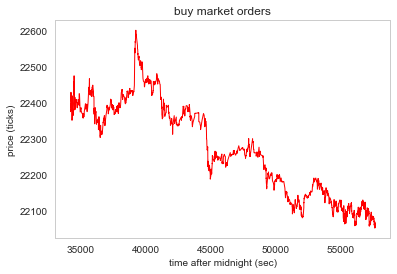

Average inter-time between two market buys =  4.24362633322  sec
Average price of market buys =  22243.380507706257  ticks
Standard deviation price of market buys =  146.497936735  ticks


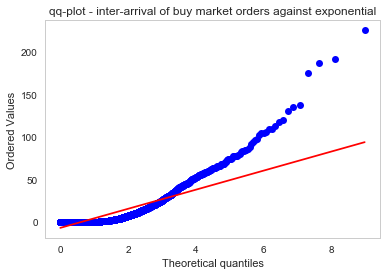

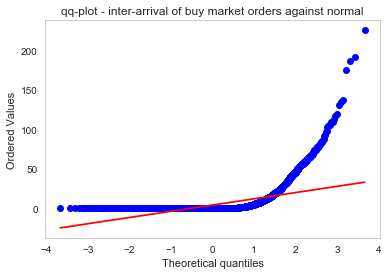

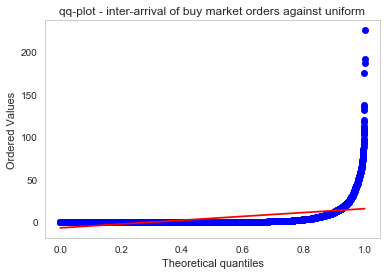

In [14]:
# here we work on the market buys
title = 'buy market orders'
plt.figure()
lines = plt.plot(market_b[0], market_b[4]/100)
plt.setp(lines, 'color', 'r', 'linewidth', 1.0)
plt.xlabel('time after midnight (sec)', fontsize=10)
plt.ylabel('price (ticks)', fontsize=10)
plt.title(title)
plt.show()

inter_t = np.zeros(market_b[0].size - 1)
for i in range(1,market_b[0].size):
    inter_t[i-1] = market_b[0].iloc[i] - market_b[0].iloc[i-1]
    
print('Average inter-time between two market buys = ', np.mean(inter_t),' sec')
print('Average price of market buys = ', np.mean(market_b[4]/100),' ticks')
print('Standard deviation price of market buys = ', np.sqrt(np.var(market_b[4]/100)),' ticks')

import pylab 
import scipy.stats as stats
stats.probplot(inter_t, dist="expon", plot=pylab)
pylab.title('qq-plot - inter-arrival of buy market orders against exponential')
pylab.show()

import pylab 
import scipy.stats as stats
stats.probplot(inter_t, dist="norm", plot=pylab)
pylab.title('qq-plot - inter-arrival of buy market orders against normal')
pylab.show()

import pylab 
import scipy.stats as stats
stats.probplot(inter_t, dist="uniform", plot=pylab)
pylab.title('qq-plot - inter-arrival of buy market orders against uniform')
pylab.show()

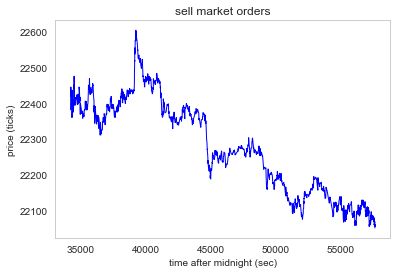

Average inter-time between two market sells =  3.96395469159  sec
Average price of market sells =  22266.129573170732  ticks
Standard deviation price of market sells =  154.696659519  ticks


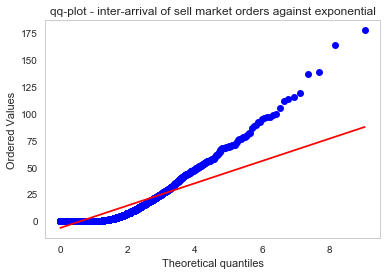

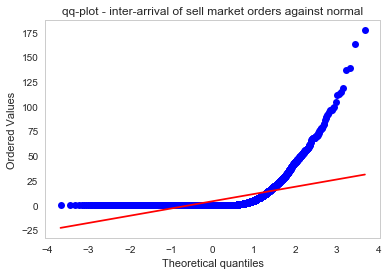

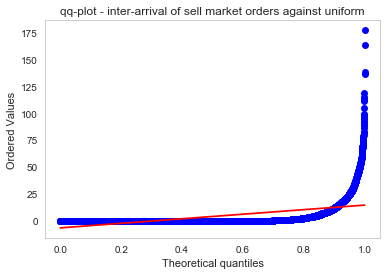

In [15]:
# here we work on the market sells
title = 'sell market orders'
plt.figure()
lines = plt.plot(market_s[0], market_s[4]/100)
plt.setp(lines, 'color', 'b', 'linewidth', 1.0)
plt.xlabel('time after midnight (sec)', fontsize=10)
plt.ylabel('price (ticks)', fontsize=10)
plt.title(title)
plt.show()

inter_t = np.zeros(market_s[0].size - 1)
for i in range(1,market_s[0].size):
    inter_t[i-1] = market_s[0].iloc[i] - market_s[0].iloc[i-1]
    
print('Average inter-time between two market sells = ', np.mean(inter_t),' sec')
print('Average price of market sells = ', np.mean(market_s[4]/100),' ticks')
print('Standard deviation price of market sells = ', np.sqrt(np.var(market_s[4]/100)),' ticks')

import pylab 
import scipy.stats as stats
stats.probplot(inter_t, dist="expon", plot=pylab)
pylab.title('qq-plot - inter-arrival of sell market orders against exponential')
pylab.show()

import pylab 
import scipy.stats as stats
stats.probplot(inter_t, dist="norm", plot=pylab)
pylab.title('qq-plot - inter-arrival of sell market orders against normal')
pylab.show()

import pylab 
import scipy.stats as stats
stats.probplot(inter_t, dist="uniform", plot=pylab)
pylab.title('qq-plot - inter-arrival of sell market orders against uniform')
pylab.show()

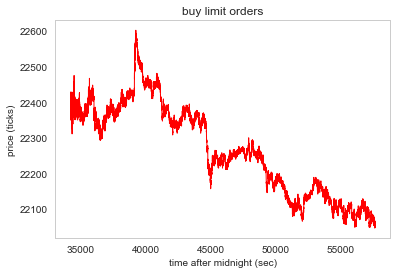

Average inter-time between two limit buys =  0.623214549453  sec
Average price of limit buys =  22270.80091618505  ticks
Standard deviation price of limit buys =  132.238090323  ticks


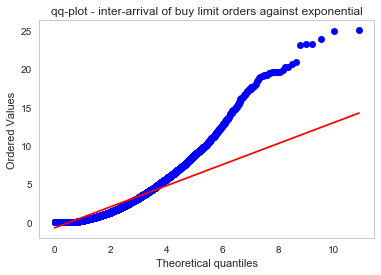

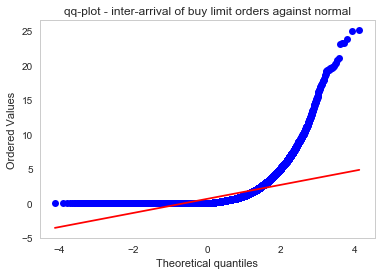

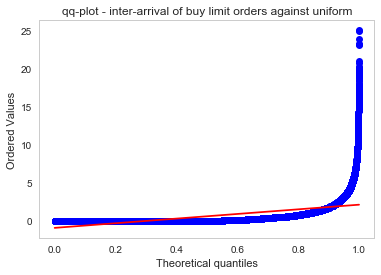

In [16]:
# here we work on the limit buys
title = 'buy limit orders'
plt.figure()
lines = plt.plot(limit_b[0], limit_b[4]/100)
plt.setp(lines, 'color', 'r', 'linewidth', 1.0)
plt.xlabel('time after midnight (sec)', fontsize=10)
plt.ylabel('price (ticks)', fontsize=10)
plt.title(title)
plt.show()

inter_t = np.zeros(limit_b[0].size - 1)
for i in range(1,limit_b[0].size):
    inter_t[i-1] = limit_b[0].iloc[i] - limit_b[0].iloc[i-1]
    
print('Average inter-time between two limit buys = ', np.mean(inter_t),' sec')
print('Average price of limit buys = ', np.mean(limit_b[4]/100),' ticks')
print('Standard deviation price of limit buys = ', np.sqrt(np.var(limit_b[4]/100)),' ticks')

import pylab 
import scipy.stats as stats
stats.probplot(inter_t, dist="expon", plot=pylab)
pylab.title('qq-plot - inter-arrival of buy limit orders against exponential')
pylab.show()

import pylab 
import scipy.stats as stats
stats.probplot(inter_t, dist="norm", plot=pylab)
pylab.title('qq-plot - inter-arrival of buy limit orders against normal')
pylab.show()

import pylab 
import scipy.stats as stats
stats.probplot(inter_t, dist="uniform", plot=pylab)
pylab.title('qq-plot - inter-arrival of buy limit orders against uniform')
pylab.show()

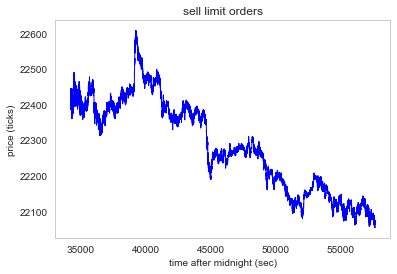

Average inter-time between two limit sells =  0.58744680634  sec
Average price of limit sells =  22295.625696641062  ticks
Standard deviation price of limit sells =  139.970079175  ticks


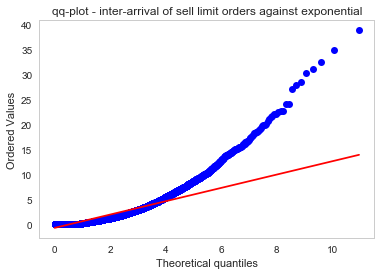

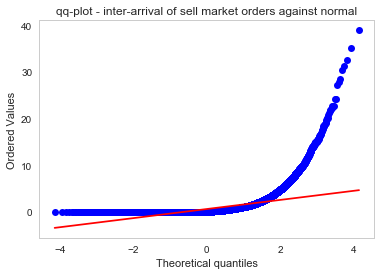

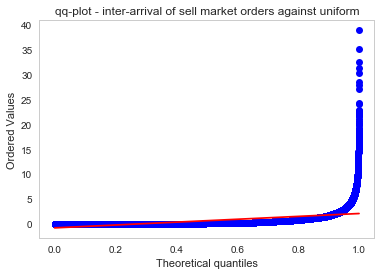

In [17]:
# here we work on the limit sells
title = 'sell limit orders'
plt.figure()
lines = plt.plot(limit_s[0], limit_s[4]/100)
plt.setp(lines, 'color', 'b', 'linewidth', 1.0)
plt.xlabel('time after midnight (sec)', fontsize=10)
plt.ylabel('price (ticks)', fontsize=10)
plt.title(title)
plt.show()

inter_t = np.zeros(limit_s[0].size - 1)
for i in range(1,limit_s[0].size):
    inter_t[i-1] = limit_s[0].iloc[i] - limit_s[0].iloc[i-1]
    
print('Average inter-time between two limit sells = ', np.mean(inter_t),' sec')
print('Average price of limit sells = ', np.mean(limit_s[4]/100),' ticks')
print('Standard deviation price of limit sells = ', np.sqrt(np.var(limit_s[4]/100)),' ticks')

import pylab 
import scipy.stats as stats
stats.probplot(inter_t, dist="expon", plot=pylab)
pylab.title('qq-plot - inter-arrival of sell limit orders against exponential')
pylab.show()

import pylab 
import scipy.stats as stats
stats.probplot(inter_t, dist="norm", plot=pylab)
pylab.title('qq-plot - inter-arrival of sell market orders against normal')
pylab.show()

import pylab 
import scipy.stats as stats
stats.probplot(inter_t, dist="uniform", plot=pylab)
pylab.title('qq-plot - inter-arrival of sell market orders against uniform')
pylab.show()

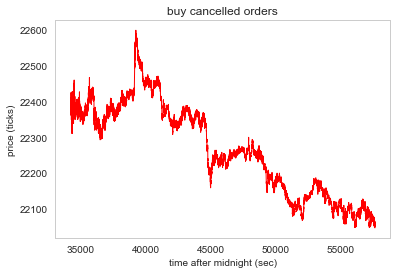

Average inter-time between two cancelled buys =  0.698020014714  sec
Average price of cancelled buys =  22272.23243743102  ticks
Standard deviation price of cancelled buys =  131.27535659  ticks


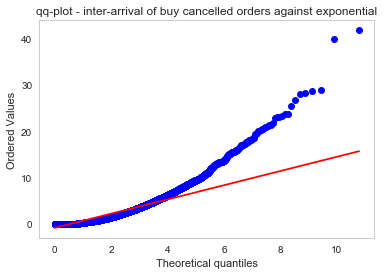

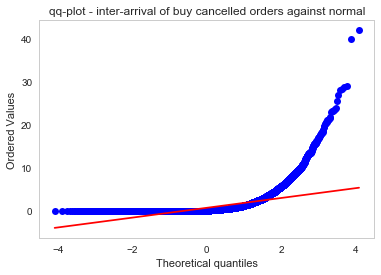

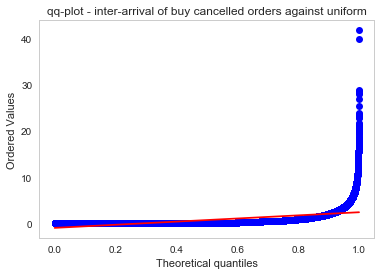

In [18]:
# here we work on the cancelled buys
title = 'buy cancelled orders'
plt.figure()
lines = plt.plot(cancelled_b[0], cancelled_b[4]/100)
plt.setp(lines, 'color', 'r', 'linewidth', 1.0)
plt.xlabel('time after midnight (sec)', fontsize=10)
plt.ylabel('price (ticks)', fontsize=10)
plt.title(title)
plt.show()

inter_t = np.zeros(cancelled_b[0].size - 1)
for i in range(1,cancelled_b[0].size):
    inter_t[i-1] = cancelled_b[0].iloc[i] - cancelled_b[0].iloc[i-1]
    
print('Average inter-time between two cancelled buys = ', np.mean(inter_t),' sec')
print('Average price of cancelled buys = ', np.mean(cancelled_b[4]/100),' ticks')
print('Standard deviation price of cancelled buys = ', np.sqrt(np.var(cancelled_b[4]/100)),' ticks')

import pylab 
import scipy.stats as stats
stats.probplot(inter_t, dist="expon", plot=pylab)
pylab.title('qq-plot - inter-arrival of buy cancelled orders against exponential')
pylab.show()

import pylab 
import scipy.stats as stats
stats.probplot(inter_t, dist="norm", plot=pylab)
pylab.title('qq-plot - inter-arrival of buy cancelled orders against normal')
pylab.show()

import pylab 
import scipy.stats as stats
stats.probplot(inter_t, dist="uniform", plot=pylab)
pylab.title('qq-plot - inter-arrival of buy cancelled orders against uniform')
pylab.show()

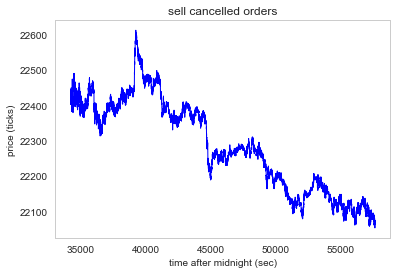

Average inter-time between two cancelled sells =  0.696154413839  sec
Average price of cancelled sells =  22297.130340354634  ticks
Standard deviation price of cancelled sells =  138.640772195  ticks


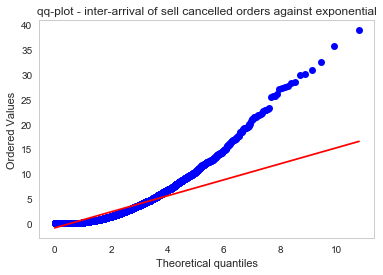

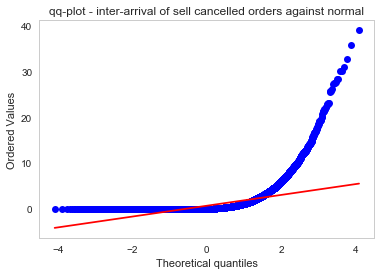

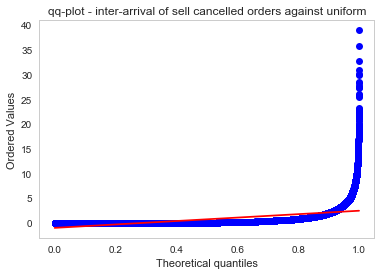

In [19]:
# here we work on the cancelled sells
title = 'sell cancelled orders'
plt.figure()
lines = plt.plot(cancelled_s[0], cancelled_s[4]/100)
plt.setp(lines, 'color', 'b', 'linewidth', 1.0)
plt.xlabel('time after midnight (sec)', fontsize=10)
plt.ylabel('price (ticks)', fontsize=10)
plt.title(title)
plt.show()

inter_t = np.zeros(cancelled_s[0].size - 1)
for i in range(1,cancelled_s[0].size):
    inter_t[i-1] = cancelled_s[0].iloc[i] - cancelled_s[0].iloc[i-1]
    
print('Average inter-time between two cancelled sells = ', np.mean(inter_t),' sec')
print('Average price of cancelled sells = ', np.mean(cancelled_s[4]/100),' ticks')
print('Standard deviation price of cancelled sells = ', np.sqrt(np.var(cancelled_s[4]/100)),' ticks')

import pylab 
import scipy.stats as stats
stats.probplot(inter_t, dist="expon", plot=pylab)
pylab.title('qq-plot - inter-arrival of sell cancelled orders against exponential')
pylab.show()


import pylab 
import scipy.stats as stats
stats.probplot(inter_t, dist="norm", plot=pylab)
pylab.title('qq-plot - inter-arrival of sell cancelled orders against normal')
pylab.show()

import pylab 
import scipy.stats as stats
stats.probplot(inter_t, dist="uniform", plot=pylab)
pylab.title('qq-plot - inter-arrival of sell cancelled orders against uniform')
pylab.show()

<b> PART 2 - get some descriptive info of the lob

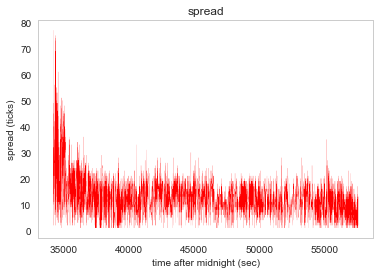

Average spread =  13.48323339853144  ticks
Standatd deviation spread =  6.21789547127  ticks


In [20]:
# here we work on the spread
spreads = lob['Ask_Price_1'] - lob['Bid_Price_1']
title = 'spread'
plt.figure()
lines = plt.plot(lob['Time'], spreads/100)
plt.setp(lines, 'color', 'r', 'linewidth', 0.1)
plt.xlabel('time after midnight (sec)', fontsize=10)
plt.ylabel('spread (ticks)', fontsize=10)
plt.title(title)
plt.show()

print('Average spread = ',np.mean(spreads/100),' ticks')
print('Standatd deviation spread = ',np.sqrt(np.var(spreads/100)),' ticks')

In [21]:
# here we work on the number of signals/ sec (like in Rama Cont's paper)
start = lob['Time'].iloc[0]
end = lob['Time'].iloc[-1]
avg_sig = 0
itr = 1
while(start<end):
    lim_cur = limit_b[(limit_b[0] >= start) & (limit_b[0] <= start+1)]
    avg_sig = avg_sig + np.sum(lim_cur[3])
    lim_cur = limit_s[(limit_s[0] >= start) & (limit_s[0] <= start+1)]
    avg_sig = avg_sig + np.sum(lim_cur[3])
    start = start + 1
    itr = itr + 1
avg_sig = avg_sig/itr

print('Average number of orders per sec = ',avg_sig)

Average number of orders per sec =  277.03709243194737


In [22]:
# here we work on the number of signals/ 10 sec (like in Rama Cont's paper)
start = lob['Time'].iloc[0]
end = lob['Time'].iloc[-1]
avg_sig = 0
itr = 1
while(start<end):
    lim_cur = limit_b[(limit_b[0] >= start) & (limit_b[0] <= start+10)]
    avg_sig = avg_sig + np.sum(lim_cur[3])
    lim_cur = limit_s[(limit_s[0] >= start) & (limit_s[0] <= start+10)]
    avg_sig = avg_sig + np.sum(lim_cur[3])
    start = start + 10
    itr = itr + 1
avg_sig = avg_sig/itr

print('Average number of orders per 10 sec = ',avg_sig)

Average number of orders per 10 sec =  2769.3058521999146


In [23]:
# here we work on the changes of price
prices = np.array(0.5*(lob['Ask_Price_1'] + lob['Bid_Price_1']))

changes = np.zeros(prices.size-1)
num_changes = 0
for i in range(1,prices.size):
    changes[i-1] = prices[i] - prices[i-1]
    if(prices[i] != prices[i-1]):
        num_changes = num_changes + 1
        
print('Price changes in 1 day = ',num_changes)
print('Max change = ',np.max(np.abs(changes))/100)
print('Min change = ',np.min(np.abs(changes))/100)
print('Mean change = ',np.mean(np.abs(changes))/100)
print('Std change = ',np.sqrt(np.var(np.abs(changes))/100))

Price changes in 1 day =  27557
Max change =  33.0
Min change =  0.0
Mean change =  0.263380661049
Std change =  9.28561622757


In [24]:
# here we work on the changes of price for 1 sec
start = lob['Time'].iloc[0]
end = lob['Time'].iloc[-1]
changes = []
while(start<end):
    lob_cur = lob[(lob['Time'] >= start) & (lob['Time'] <= start+1)]
    if(lob_cur.size==0):
        start = start + 1
        continue
    p1 = 0.5*(lob_cur['Ask_Price_1'].iloc[0] + lob_cur['Bid_Price_1'].iloc[0])
    p2 = 0.5*(lob_cur['Ask_Price_1'].iloc[-1] + lob_cur['Bid_Price_1'].iloc[-1])
    changes.append(p2-p1)
    start = start + 1
changes = np.array(changes)

print('Price changes (T=1sec) in 1 day = ',changes[changes==0].size)
print('Max change = ',np.max(np.abs(changes))/100)
print('Min change = ',np.min(np.abs(changes))/100)
print('Mean change = ',np.mean(np.abs(changes))/100)
print('Std change = ',np.sqrt(np.var(np.abs(changes))/100))

Price changes (T=1sec) in 1 day =  10046
Max change =  36.0
Min change =  0.0
Mean change =  0.918543005052
Std change =  20.9816647903


In [25]:
# here we work on the changes of price for 10 sec
start = lob['Time'].iloc[0] + 3600
end = lob['Time'].iloc[-1]
changes = []
while(start<end):
    lob_cur = lob[(lob['Time'] >= start) & (lob['Time'] <= start+10)]
    if(lob_cur.size==0):
        start = start + 10
        continue
    p1 = 0.5*(lob_cur['Ask_Price_1'].iloc[0] + lob_cur['Bid_Price_1'].iloc[0])
    p2 = 0.5*(lob_cur['Ask_Price_1'].iloc[-1] + lob_cur['Bid_Price_1'].iloc[-1])
    changes.append(p2-p1)
    start = start + 10
changes = np.array(changes)

print('Price changes (T=10sec) in 1 day = ',changes[changes==0].size)
print('Max change = ',np.max(np.abs(changes))/100)
print('Min change = ',np.min(np.abs(changes))/100)
print('Mean change = ',np.mean(np.abs(changes))/100)
print('Std change = ',np.sqrt(np.var(np.abs(changes))/100))

Price changes (T=10sec) in 1 day =  334
Max change =  45.5
Min change =  0.0
Mean change =  3.76012145749
Std change =  45.0004484744


Average limit order book depth =  146.937718921
Standard Deviation limit order book depth =  19.1779909986


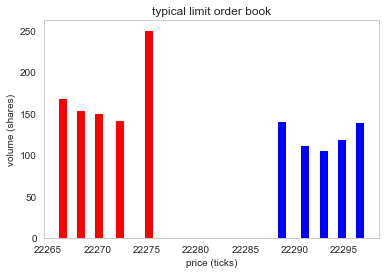

In [26]:
# here we give an idea of an "average" order book
avg_b5 = lob['Bid_Price_5'].mean()
avg_b4 = lob['Bid_Price_4'].mean()
avg_b3 = lob['Bid_Price_3'].mean()
avg_b2 = lob['Bid_Price_2'].mean()
avg_b1 = lob['Bid_Price_1'].mean()
avg_a1 = lob['Ask_Price_1'].mean()
avg_a2 = lob['Ask_Price_2'].mean()
avg_a3 = lob['Ask_Price_3'].mean()
avg_a4 = lob['Ask_Price_4'].mean()
avg_a5 = lob['Ask_Price_5'].mean()

avg_b5s = lob['Bid_Size_5'].mean()
avg_b4s = lob['Bid_Size_4'].mean()
avg_b3s = lob['Bid_Size_3'].mean()
avg_b2s = lob['Bid_Size_2'].mean()
avg_b1s = lob['Bid_Size_1'].mean()
avg_a1s = lob['Ask_Size_1'].mean()
avg_a2s = lob['Ask_Size_2'].mean()
avg_a3s = lob['Ask_Size_3'].mean()
avg_a4s = lob['Ask_Size_4'].mean()
avg_a5s = lob['Ask_Size_5'].mean()

avg_b5v = lob['Bid_Size_5'].var()
avg_b4v = lob['Bid_Size_4'].var()
avg_b3v = lob['Bid_Size_3'].var()
avg_b2v = lob['Bid_Size_2'].var()
avg_b1v = lob['Bid_Size_1'].var()
avg_a1v = lob['Ask_Size_1'].var()
avg_a2v = lob['Ask_Size_2'].var()
avg_a3v = lob['Ask_Size_3'].var()
avg_a4v = lob['Ask_Size_4'].var()
avg_a5v = lob['Ask_Size_5'].var()

X = np.array([avg_b5,avg_b4,avg_b3,avg_b2,avg_b1,avg_a1,avg_a2,avg_a3,avg_a4,avg_a5])/100
Y = np.array([avg_b5s,avg_b4s,avg_b3s,avg_b2s,avg_b1s,avg_a1s,avg_a2s,avg_a3s,avg_a4s,avg_a5s])
Z = np.sqrt(np.sqrt(np.array([avg_b5v,avg_b4v,avg_b3v,avg_b2v,avg_b1v,avg_a1v,avg_a2v,avg_a3v,avg_a4v,avg_a5v])))

print('Average limit order book depth = ',np.mean(Y))
print('Standard Deviation limit order book depth = ',np.mean(Z))

title = 'typical limit order book'
plt.figure()
#lines = plt.plot(lob['Time'], spreads/100)
#plt.setp(lines, 'color', 'r', 'linewidth', 0.1)
plt.bar(X,Y, color=['r','r','r','r','r','b','b','b','b','b'])
plt.xlabel('price (ticks)', fontsize=10)
plt.ylabel('volume (shares)', fontsize=10)
plt.title(title)
plt.show()